### Setup and imports

In [78]:

import os
import tensorflow as tf
import matplotlib.pyplot as plt

### Process data

In [79]:
# Use 32 samples from the training dataset to estimate the error
# gradient before updating the model weights
batch_size = 32

img_height = 64
img_width = 64

data_dir = "../datasets/processed-celeba-small/processed_celeba_small/"

# Import images from a directory
# Seed for shuffling and transformations so they are deterministic
# rescale them to the height and width
# divide them up in batches
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=1337,
  label_mode=None,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Models train better on small input values and we use tanh, therefore we normalize to values between [-1, 1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
train_ds = train_ds.map(lambda x: (normalization_layer(x)))

# import matplotlib.pyplot as plt
#
# plt.figure(figsize=(10, 10))
# for images in train_ds.take(1):
#   images *= 255
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title("Image")
#     plt.axis("off")

Found 32600 files belonging to 1 classes.


### Create the generator

In [80]:
# Space from which the generator converts a point to an image or face in this case
latent_dim = 64

generator = tf.keras.Sequential([
  # Input Layer
  tf.keras.Input(shape=(latent_dim,)),

  # A densely-connected NN layer with 8 * 8 * 128 neurons(units)
  tf.keras.layers.Dense(8 * 8 * 128),
  # A leaky version of a ReLU, when the unit is not active it allows for a small gradient
  # A normal ReLU can cause a neuron to die
  # leaky ReLU prevents this to allow a small slope for negative values
  tf.keras.layers.LeakyReLU(alpha=0.2),

  # Back to a rank of 4 so the conv2D layers can function
  tf.keras.layers.Reshape((8, 8, 128)),

  # Up sampling and Conv2D in one layer
  tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
  tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.Conv2D(3, (7, 7), padding="same", activation="tanh"),
], name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 8192)              532480    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 32, 32, 128)       0 

### Create the discriminator

In [81]:
discriminator = tf.keras.Sequential([
  # Input a 64*64 image with 3 channels(RGB)
  tf.keras.Input(shape=(64, 64, 3)),

  # Convolutional layer
  tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
  tf.keras.layers.LeakyReLU(alpha=0.2),

  # Second convolutional layer
  tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
  tf.keras.layers.LeakyReLU(alpha=0.2),

  # Group the best values
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Dense(1),

], name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 75,777
Trainable params: 75,777
Non-trainable params: 0
_________________________________________________

### Override the train_step

In [82]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Decode them to fake images
    generated_images = self.generator(random_latent_vectors)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat([
      tf.ones((batch_size, 1)),
      tf.zeros((batch_size, 1))
    ], axis=0)

    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))


    # Train the discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    return {"d_loss": d_loss, "g_loss": g_loss}

### Create a callback save images

In [83]:
class GANMonitor(tf.keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images = generated_images * 127.5 + 127.5
    generated_images.numpy()

    plt.figure(figsize=(4,4))
    for i in range(self.num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        plt.subplot(4, 4, i+1)
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
    if not os.path.exists('images'):
      os.makedirs('images')
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Create a callback save model

In [84]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

### Train the end-to-end model

Epoch 1/30000
1018/1019 [============================>.] - ETA: 0s - d_loss: 0.6994 - g_loss: 0.8302

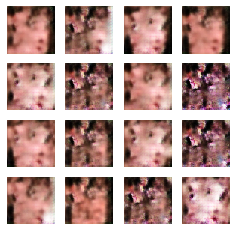


Epoch 00001: saving model to training_1\cp.ckpt
1019/1019 [==============================] - 87s 85ms/step - d_loss: 0.6994 - g_loss: 0.8300
Epoch 2/30000
 379/1019 [==========>...................] - ETA: 47s - d_loss: 0.7005 - g_loss: 0.7662

In [ ]:
epochs = 30000

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.load_weights(checkpoint_path)

gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    train_ds, epochs=epochs, callbacks=[GANMonitor(num_img=16, latent_dim=latent_dim), cp_callback]
)

### Make GIF